In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [17]:
image_folder_path = Path('DIP2025\\Assignment2\\images')
all_images = []
for image_path in image_folder_path.glob('*'):
    if image_path.is_file():
        try:
            with Image.open(image_path) as img:
                all_images.append(img.copy())
            print(f"Loaded image: {image_path.name}")
        except IOError:
            print(f"Could not load image: {image_path.name}")
print(f"\nSuccessfully loaded {len(all_images)} images.")


Loaded image: flowers.png
Loaded image: moon_noisy.png
Loaded image: sharp.png
Loaded image: study.png

Successfully loaded 4 images.


In [18]:
flowers, moon_noisy, sharp, study = all_images

In [41]:
class FilteringAndBinarization:
    def __init__(self, m):
        self.m = m

    def box_filter(self, m):
        box = np.ones((m, m), dtype=float)
        return box / (m * m)

    def convolve(self, image, kernel):
        if isinstance(image, Image.Image):
            image = image.convert('L')
            image = np.array(image)
        elif image.ndim == 3:  # RGB as np array
            image = np.mean(image, axis=2).astype(np.uint8) # Simply taking the mean of values of channels

        kernel_size = kernel.shape[0]
        pad = kernel_size // 2
        rows, cols = image.shape

        padded = np.pad(image, pad, mode='reflect')
        conv_image = np.zeros_like(image, dtype=float)

        for i in range(rows):
            for j in range(cols):
                patch = padded[i:i+kernel_size, j:j+kernel_size]
                conv_image[i, j] = np.sum(patch * kernel)

        return conv_image.astype(np.uint8)

    def histogram_compute(self, img):
        if isinstance(img, Image.Image):
            img = img.convert('L')
            img = np.array(img)
        elif img.ndim == 3:  # RGB as np array
            img = np.mean(img, axis=2).astype(np.uint8) 

        gray_img = img.ravel()
        mn = len(gray_img)
        hist, bins = np.histogram(gray_img, bins=256, range=(0, 256))
        return hist / mn

    def otsu_binarization(self, norm_histogram, threshold):
        class0_prob = np.sum(norm_histogram[:threshold+1])
        class1_prob = 1 - class0_prob

        if class0_prob > 0:
            class0_mean = np.sum(np.arange(0, threshold+1) * norm_histogram[:threshold+1]) / class0_prob
        else:
            class0_mean = 0

        if class1_prob > 0:
            class1_mean = np.sum(np.arange(threshold+1, 256) * norm_histogram[threshold+1:]) / class1_prob
        else:
            class1_mean = 0

        return class0_prob * class1_prob * (class1_mean - class0_mean) ** 2

    def otsu_threshold(self, img):
        # Compute normalized histogram
        norm_hist = self.histogram_compute(img)
        # Maximize between-class variance
        variances = [self.otsu_binarization(norm_hist, t) for t in range(256)]
        return np.argmax(variances)


In [85]:
kernel_sizes = [5,29,129]
bw_variances = []
OtsuThresholds = []
bin_images = []
hists = []

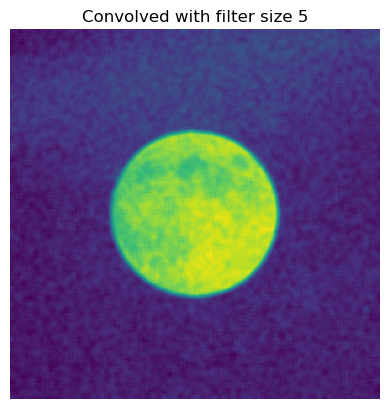

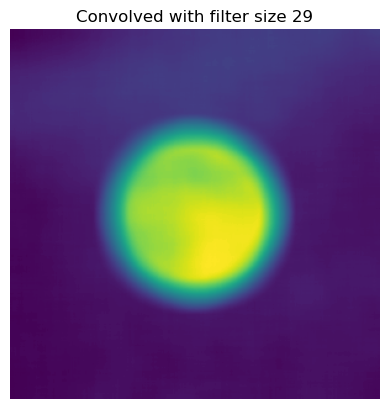

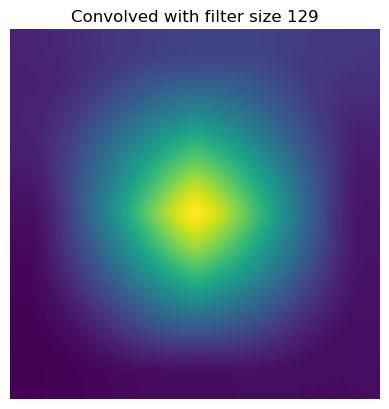

In [86]:
for m in [5, 29, 129]:
    q1 = FilteringAndBinarization(m)
    kernel = q1.box_filter(m)
    conv_img = q1.convolve(moon_noisy, kernel)
    
    # Store raw intensities (for plotting histograms later)
    hists.append(conv_img.ravel())
    
    # Normalized histogram
    norm_hist = q1.histogram_compute(conv_img)
    
    # Otsu threshold
    threshold = q1.otsu_threshold(conv_img)
    OtsuThresholds.append(threshold)
    
    # Between-class variance
    bw_variances.append(q1.otsu_binarization(norm_hist, threshold=threshold))
    
    # Binarization
    binary_img = conv_img.copy()
    binary_img[binary_img <= threshold] = 0
    binary_img[binary_img > threshold] = 1
    bin_images.append(binary_img)
    
    # Show original convolved (grayscale)
    plt.imshow(conv_img)
    plt.axis('off')
    plt.title(f"Convolved with filter size {m}")
    plt.show()


In [88]:
for i in range(len(bw_variances)):
    print(f"Between class variance for kernel size {kernel_sizes[i]} is {bw_variances[i]:0.2f}")

Between class variance for kernel size 5 is 2960.26
Between class variance for kernel size 29 is 2397.43
Between class variance for kernel size 129 is 761.02


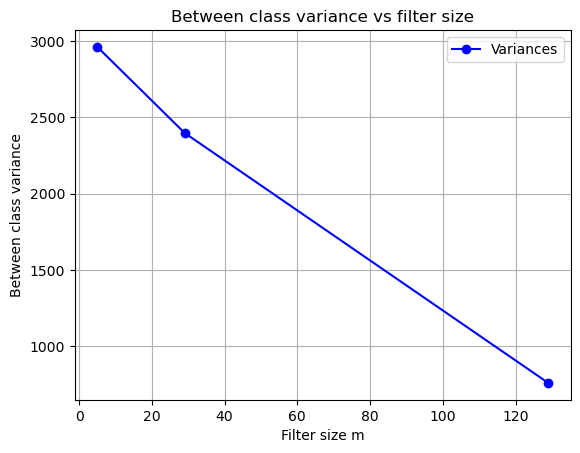

In [73]:
plt.plot([5,29, 129], bw_variances, marker = 'o', color= 'b', label='Variances')
plt.legend()
plt.title("Between class variance vs filter size")
plt.xlabel("Filter size m")
plt.ylabel("Between class variance")
plt.grid(True)
plt.show()


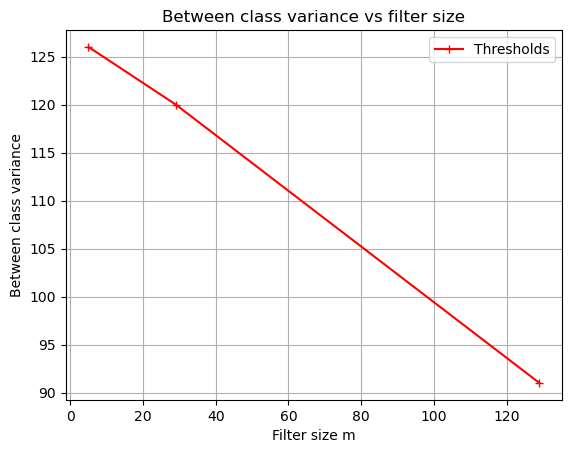

In [74]:
plt.plot([5,29, 129], OtsuThresholds, marker = '+', color= 'r', label = 'Thresholds')
plt.legend()
plt.title("Between class variance vs filter size")
plt.xlabel("Filter size m")
plt.ylabel("Between class variance")
plt.grid(True)
plt.show()

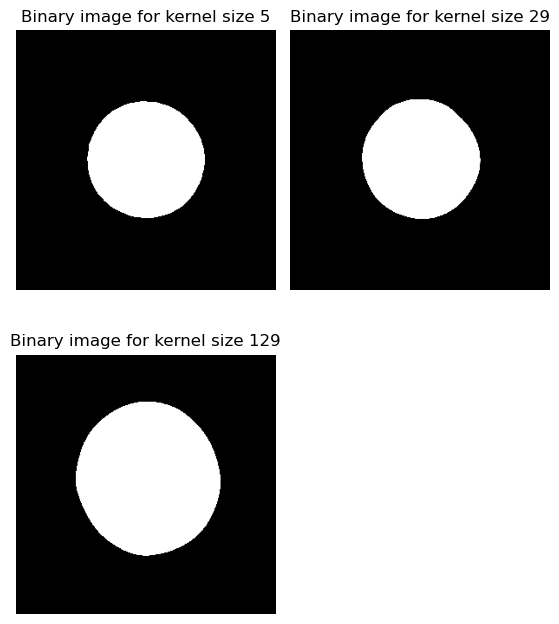

In [ ]:
plt.figure(figsize=(6,7))
for i, bin_img in enumerate(bin_images):
    plt.subplot(2,2,i+1)
    plt.imshow(bin_img, cmap='gray')
    plt.tight_layout()
    plt.title(f"Binary image for kernel size {kernel_sizes[i]}")
    plt.axis('off')
plt.show()

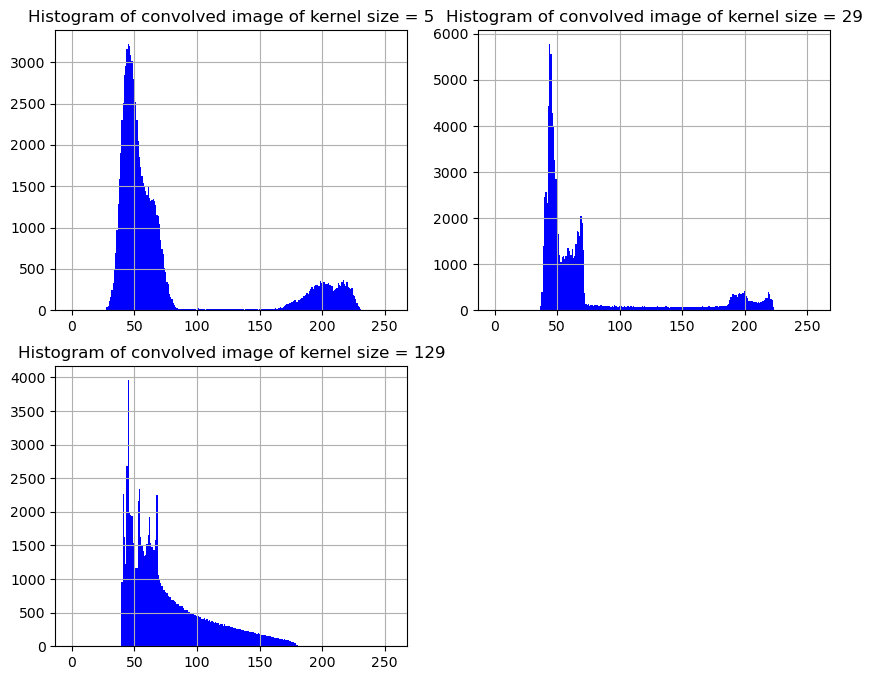

In [84]:
plt.figure(figsize=(10,8))
for i,hist_array in enumerate(hists):
    plt.subplot(2,2,i+1)
    hist, bins=np.histogram(hist_array, bins=256, range=(0,256))
    plt.bar(bins[:-1], hist, width=1, color='blue')
    plt.grid(True)
    plt.title(f"Histogram of convolved image of kernel size = {kernel_sizes[i]}")
plt.show()